# Description
- Import the data
- Segment data into 2 turn segments
- Calculate the FFT
- Solve for the DFT ratio
- Calculate the SVD of the dft ratio, dft(strain), dft(angular velocity).
- Genrate scatter plots

## Import Packages

In [1]:
# For calculating derivatives and integrals
import math
import pynumdiff
import scipy
import cvxpy as cp
# import umap.umap_ as umap
# from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn import metrics

# For processing data
import numpy as np
import pandas as pd

# For calculating frequency content
from scipy import fft
from scipy import signal

# For plotting signals
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Functions

In [2]:
# Perform a mean subtraction to ensure data is centered around the zero.
def sig_mean_df(df, columns,time):
    df_mean = pd.DataFrame(columns=columns)
    for i in range(len(columns)):
        signal = df[columns[i]]
        signal_mean = np.mean(signal)
        signal_use = (signal-signal_mean)
        df_mean[columns[i]] = signal_use
    df_mean[time] = df[time]
    
    return(df_mean)

# Smooth your data like butter. Return original dataframe with smoothed data appended.
def smooth_butter(df, params, dt, col_names):
    for i in range(np.size(col_names)):
        df[col_names[i] + '_hat'], df[col_names[i] + '_dt'] = pynumdiff.smooth_finite_difference.butterdiff(df[col_names[i]], dt, params, options={'iterate': False})
    return(df)

# Smooth your data and return only smooth signals.
def smooth_only(df, params, dt, col_names):
    df_new = pd.DataFrame()
    for i in range(len(col_names)):
        smooth_data, smooth_derivative = pynumdiff.smooth_finite_difference.butterdiff(df[col_names[i]], dt, params, options={'iterate': False})
        df_new[col_names[i]] = smooth_data 
    return(df_new)

# Calculate the DFT of a data set and return a data frame including the DFT data
def simple_fft_array(array,dt):
    fft_df = pd.DataFrame()
    N = np.shape(array)[0]
    yf = 2.0/N * np.abs(fft.fft(array)[0:N//2])
    xf = fft.fftfreq(N,dt)[:N//2]
    fft_df['array_fft'] = yf
    fft_df['frequency'] = xf
    return(fft_df)

# Take the FFT of a dataset and return a new data frame containing the DFT data.
def fft_of_data_df(df,dt,columns):
    fft_df = pd.DataFrame()
    for i in range(len(columns)):
        data = df[columns[i]]
        data = np.array(data)
        N = data.shape[0] # Length of data.
        yf = 2.0/N * np.abs(fft.fft(data)[0:N//2])# Divide to bring the manitude to the magnitude of the orginal sinewave.
        # Remember the the y-data will be complex so you have to take the absolute value.
        xf = fft.fftfreq(N,dt)[:N//2]# Only take the first half of the data.
        fft_df[columns[i]+'_fft'] = yf
        if i == len(columns)-1:
            fft_df['Frequency'] = xf
    return(fft_df)

# Use query to extract segments of data.
def segment_data(df, column_title, lower_lim, upper_lim):
    q = column_title + ' < ' + str(upper_lim) + ' and ' + column_title + ' > ' + str(lower_lim)
    new_df = df.query(q)
    return(new_df)

# Segment the data into desired segment size and take the FFT of the signals
# Return a new data frame.
def segment_create_new_df_for_each_sg(list_of_dfs,strain_gauge,chunck_size,snow_types,dt):
    lower_freq = 1/60
    high_freq = 150
    df_new = pd.DataFrame()
#     dataframes = np.shape(list_of_dfs[0])[0]
    data_frames = len(snow_types)-1
    for j in range(data_frames):
            df_column = list_of_dfs[j][strain_gauge]
            n = len(df_column)//chunk_size
            for i in range(n):
                data = df_column[i*chunk_size:(i+1)*chunk_size] # "data" is the segmented timeseries. 
                df_new[df_column.name+'_'+str(i+1)+'_'+snow_types[j]] = data.reset_index(drop=True)
    df_new = fft_of_data_df(df_new,dt,df_new.columns.tolist())
    # Take every 5th entry.
    df_new = segment_data(df_new,'Frequency',lower_freq,high_freq) #.iloc[0::2,:].reset_index(drop=True)
    return(df_new)

## Code

## 1.0 Load data and format data

In [3]:
# Import ski data
df_grmr = pd.read_hdf('DATA/df_grmr.hdf')
df_grmr1 = pd.read_hdf('DATA/df_grmr1.hdf')
df_grmr2 = pd.read_hdf('DATA/df_grmr2.hdf')
df_grmr3 = pd.read_hdf('DATA/df_grmr3.hdf')
df_grmr4 = pd.read_hdf('DATA/df_grmr4.hdf')
df_grmr5 = pd.read_hdf('DATA/df_grmr5.hdf')

df_pwdr = pd.read_hdf('DATA/df_pwdr.hdf')
df_pwdr1 = pd.read_hdf('DATA/df_pwdr1.hdf')

df_icy = pd.read_hdf('DATA/df_icy.hdf')

df_s = pd.read_hdf('DATA/df_s.hdf')
df_s1 = pd.read_hdf('DATA/df_s1.hdf')
df_s2 = pd.read_hdf('DATA/df_s2.hdf')
df_s3 = pd.read_hdf('DATA/df_s3.hdf')

2022-06-09 08:38:06,769 [INFO] NumExpr defaulting to 4 threads.


In [4]:
# Create data frames that are mean subtracted.
columns = ['sg3','sg4','sg6','sgc','sg7','sg12','sg15','imu_ax','imu_ay','imu_az','imu_wx','imu_wy','imu_wz'] # Columns to use.
df_grmr_mean  = sig_mean_df(df_grmr,columns,'time_imu')
df_grmr1_mean = sig_mean_df(df_grmr1,columns,'time_imu')
df_grmr2_mean = sig_mean_df(df_grmr2,columns,'time_imu')
df_grmr3_mean = sig_mean_df(df_grmr3,columns,'time_imu')
df_grmr4_mean = sig_mean_df(df_grmr4,columns,'time_imu')
df_grmr5_mean = sig_mean_df(df_grmr5,columns,'time_imu')
df_pwdr_mean  = sig_mean_df(df_pwdr,columns,'time_imu')
df_pwdr1_mean = sig_mean_df(df_pwdr1,columns,'time_imu')
df_icy_mean   = sig_mean_df(df_icy,columns,'time_imu')
df_s_mean     = sig_mean_df(df_s,columns,'time_imu')
df_s1_mean    = sig_mean_df(df_s1,columns,'time_imu')
df_s2_mean    = sig_mean_df(df_s2,columns,'time_imu')
df_s3_mean    = sig_mean_df(df_s3,columns,'time_imu')
all_mean_time = [df_grmr_mean,df_grmr1_mean,df_grmr2_mean,df_grmr3_mean,df_grmr4_mean,df_grmr5_mean,
                df_pwdr_mean,df_pwdr1_mean,
                df_icy_mean,
                df_s_mean,df_s1_mean,df_s2_mean,df_s3_mean]

## 1.1 Plot strain and smoothed angular velocity data

## 1.2 Segment the data
- Segment into 2 turn segments
- Take the FFT of the data

In [5]:
# Segment the original non normalized strain data.
# And take the FFT of the signals.
dt = 0.001 # Sample period
snow_types = ['groomer_slow','groomer_slow1','groomer_fast','groomer_fast1','groomer_slow2','groomer_fast2','powder_1',
              'powder_5','icy_fast','icy1_fast','slushy_fast','slushy_slow','slushy_fast1','slushy_slow1']
strain_gauge = ['sg3','sg4','sg12','sg6','sgc','sg7','sg15']
chunk_size = 10000
sg3_segmented_all_snow = segment_create_new_df_for_each_sg(all_mean_time,strain_gauge[0],chunk_size,snow_types,dt)
sg4_segmented_all_snow = segment_create_new_df_for_each_sg(all_mean_time,strain_gauge[1],chunk_size,snow_types,dt)
sg12_segmented_all_snow = segment_create_new_df_for_each_sg(all_mean_time,strain_gauge[2],chunk_size,snow_types,dt)
sg6_segmented_all_snow = segment_create_new_df_for_each_sg(all_mean_time,strain_gauge[3],chunk_size,snow_types,dt)
sgc_segmented_all_snow = segment_create_new_df_for_each_sg(all_mean_time,strain_gauge[4],chunk_size,snow_types,dt)
sg7_segmented_all_snow = segment_create_new_df_for_each_sg(all_mean_time,strain_gauge[5],chunk_size,snow_types,dt)
sg15_segmented_all_snow = segment_create_new_df_for_each_sg(all_mean_time,strain_gauge[6],chunk_size,snow_types,dt)

strain_segmented_all_fft = [sg3_segmented_all_snow.iloc[:,0:65],sg12_segmented_all_snow.iloc[:,0:65],sg6_segmented_all_snow.iloc[:,0:65],
                           sgc_segmented_all_snow.iloc[:,0:65],sg7_segmented_all_snow.iloc[:,0:65],sg15_segmented_all_snow.iloc[:,0:65]]

ang_velx_all_snow = segment_create_new_df_for_each_sg(all_mean_time,'imu_wx',chunk_size,snow_types,dt)
ang_vely_all_snow = segment_create_new_df_for_each_sg(all_mean_time,'imu_wy',chunk_size,snow_types,dt)
ang_velz_all_snow = segment_create_new_df_for_each_sg(all_mean_time,'imu_wz',chunk_size,snow_types,dt)

angular_vel_all = [ang_velx_all_snow,ang_vely_all_snow,ang_velz_all_snow]

## 1.3 Solve for the DFT ratio 
- Do this using various "inputs"
- Inputs are the 3 axes of angular velocity measured from the IMU

In [6]:
# Calculate the DFT ratio for x axis
gamma = 0.8 # Weighting parameter for total variance constraint.
all_b3 = []
all_b12 = []
all_b6 = []
all_bc = []
all_b7 = []
all_b15 = []

for i in range(np.shape(ang_velx_all_snow)[1]-1):
    in_data = np.array(ang_velx_all_snow.iloc[:,i]).reshape((np.shape(ang_velx_all_snow.iloc[:,i])[0],1)) # The input will be the same across all strain gauges.
    out_data3 = np.array(sg3_segmented_all_snow.iloc[:,i]).reshape((np.shape(sg3_segmented_all_snow.iloc[:,i])[0],1))
    out_data12 = np.array(sg12_segmented_all_snow.iloc[:,i]).reshape((np.shape(sg12_segmented_all_snow.iloc[:,i])[0],1))
    out_data6 = np.array(sg6_segmented_all_snow.iloc[:,i]).reshape((np.shape(sg6_segmented_all_snow.iloc[:,i])[0],1))
    out_datac = np.array(sgc_segmented_all_snow.iloc[:,i]).reshape((np.shape(sgc_segmented_all_snow.iloc[:,i])[0],1))
    out_data7 = np.array(sg7_segmented_all_snow.iloc[:,i]).reshape((np.shape(sg7_segmented_all_snow.iloc[:,i])[0],1))
    out_data15 = np.array(sg15_segmented_all_snow.iloc[:,i]).reshape((np.shape(sg15_segmented_all_snow.iloc[:,i])[0],1))

    bode3 = cp.Variable(np.shape(in_data)[0]) # Numerical bode plot that resets every time, but the values are appended. 
    bode12 = cp.Variable(np.shape(in_data)[0])
    bode6 = cp.Variable(np.shape(in_data)[0])
    bodec = cp.Variable(np.shape(in_data)[0])
    bode7 = cp.Variable(np.shape(in_data)[0])
    bode15 = cp.Variable(np.shape(in_data)[0])

    L = cp.sum(cp.square(cp.multiply(in_data[:,0],bode3) - out_data3[:,0])) + gamma*cp.tv(bode3)
    objective = cp.Minimize(L)
    prob = cp.Problem(objective)
    result = prob.solve()
    all_b3.append(bode3.value)
    
    L = cp.sum(cp.square(cp.multiply(in_data[:,0],bode12) - out_data12[:,0])) + gamma*cp.tv(bode12)
    objective = cp.Minimize(L)
    prob = cp.Problem(objective)
    result = prob.solve()
    all_b12.append(bode12.value)
    
    L = cp.sum(cp.square(cp.multiply(in_data[:,0],bode6) - out_data6[:,0])) + gamma*cp.tv(bode6)
    objective = cp.Minimize(L)
    prob = cp.Problem(objective)
    result = prob.solve()
    all_b6.append(bode6.value)
    
    L = cp.sum(cp.square(cp.multiply(in_data[:,0],bodec) - out_datac[:,0])) + gamma*cp.tv(bodec)
    objective = cp.Minimize(L)
    prob = cp.Problem(objective)
    result = prob.solve()
    all_bc.append(bodec.value)
    
    L = cp.sum(cp.square(cp.multiply(in_data[:,0],bode7) - out_data7[:,0])) + gamma*cp.tv(bode7)
    objective = cp.Minimize(L)
    prob = cp.Problem(objective)
    result = prob.solve()
    all_b7.append(bode7.value)
    
    L = cp.sum(cp.square(cp.multiply(in_data[:,0],bode15) - out_data15[:,0])) + gamma*cp.tv(bode15)
    objective = cp.Minimize(L)
    prob = cp.Problem(objective)
    result = prob.solve()
    all_b15.append(bode15.value)
    
all_bode_datax = [np.transpose(all_b3),np.transpose(all_b12),np.transpose(all_b6),np.transpose(all_bc),np.transpose(all_b7),np.transpose(all_b15)]

In [7]:
# Y axis
all_b3 = []
all_b12 = []
all_b6 = []
all_bc = []
all_b7 = []
all_b15 = []

for i in range(np.shape(ang_vely_all_snow)[1]-1):
    in_data = np.array(ang_vely_all_snow.iloc[:,i]).reshape((np.shape(ang_vely_all_snow.iloc[:,i])[0],1)) # The input will be the same across all strain gauges.
    out_data3 = np.array(sg3_segmented_all_snow.iloc[:,i]).reshape((np.shape(sg3_segmented_all_snow.iloc[:,i])[0],1))
    out_data12 = np.array(sg12_segmented_all_snow.iloc[:,i]).reshape((np.shape(sg12_segmented_all_snow.iloc[:,i])[0],1))
    out_data6 = np.array(sg6_segmented_all_snow.iloc[:,i]).reshape((np.shape(sg6_segmented_all_snow.iloc[:,i])[0],1))
    out_datac = np.array(sgc_segmented_all_snow.iloc[:,i]).reshape((np.shape(sgc_segmented_all_snow.iloc[:,i])[0],1))
    out_data7 = np.array(sg7_segmented_all_snow.iloc[:,i]).reshape((np.shape(sg7_segmented_all_snow.iloc[:,i])[0],1))
    out_data15 = np.array(sg15_segmented_all_snow.iloc[:,i]).reshape((np.shape(sg15_segmented_all_snow.iloc[:,i])[0],1))

    bode3 = cp.Variable(np.shape(in_data)[0]) # Numerical bode plot that resets every time, but the values are appended. 
    bode12 = cp.Variable(np.shape(in_data)[0])
    bode6 = cp.Variable(np.shape(in_data)[0])
    bodec = cp.Variable(np.shape(in_data)[0])
    bode7 = cp.Variable(np.shape(in_data)[0])
    bode15 = cp.Variable(np.shape(in_data)[0])

    L = cp.sum(cp.square(cp.multiply(in_data[:,0],bode3) - out_data3[:,0])) + gamma*cp.tv(bode3)
    objective = cp.Minimize(L)
    prob = cp.Problem(objective)
    result = prob.solve()
    all_b3.append(bode3.value)
    
    L = cp.sum(cp.square(cp.multiply(in_data[:,0],bode12) - out_data12[:,0])) + gamma*cp.tv(bode12)
    objective = cp.Minimize(L)
    prob = cp.Problem(objective)
    result = prob.solve()
    all_b12.append(bode12.value)
    
    L = cp.sum(cp.square(cp.multiply(in_data[:,0],bode6) - out_data6[:,0])) + gamma*cp.tv(bode6)
    objective = cp.Minimize(L)
    prob = cp.Problem(objective)
    result = prob.solve()
    all_b6.append(bode6.value)
    
    L = cp.sum(cp.square(cp.multiply(in_data[:,0],bodec) - out_datac[:,0])) + gamma*cp.tv(bodec)
    objective = cp.Minimize(L)
    prob = cp.Problem(objective)
    result = prob.solve()
    all_bc.append(bodec.value)
    
    L = cp.sum(cp.square(cp.multiply(in_data[:,0],bode7) - out_data7[:,0])) + gamma*cp.tv(bode7)
    objective = cp.Minimize(L)
    prob = cp.Problem(objective)
    result = prob.solve()
    all_b7.append(bode7.value)
    
    L = cp.sum(cp.square(cp.multiply(in_data[:,0],bode15) - out_data15[:,0])) + gamma*cp.tv(bode15)
    objective = cp.Minimize(L)
    prob = cp.Problem(objective)
    result = prob.solve()
    all_b15.append(bode15.value)

all_bode_datay = [np.transpose(all_b3),np.transpose(all_b12),np.transpose(all_b6),np.transpose(all_bc),np.transpose(all_b7),np.transpose(all_b15)]

In [8]:
# Z axis
all_b3 = []
all_b12 = []
all_b6 = []
all_bc = []
all_b7 = []
all_b15 = []

for i in range(np.shape(ang_velz_all_snow)[1]-1):
    in_data = np.array(ang_velz_all_snow.iloc[:,i]).reshape((np.shape(ang_velz_all_snow.iloc[:,i])[0],1)) # The input will be the same across all strain gauges.
    out_data3 = np.array(sg3_segmented_all_snow.iloc[:,i]).reshape((np.shape(sg3_segmented_all_snow.iloc[:,i])[0],1))
    out_data12 = np.array(sg12_segmented_all_snow.iloc[:,i]).reshape((np.shape(sg12_segmented_all_snow.iloc[:,i])[0],1))
    out_data6 = np.array(sg6_segmented_all_snow.iloc[:,i]).reshape((np.shape(sg6_segmented_all_snow.iloc[:,i])[0],1))
    out_datac = np.array(sgc_segmented_all_snow.iloc[:,i]).reshape((np.shape(sgc_segmented_all_snow.iloc[:,i])[0],1))
    out_data7 = np.array(sg7_segmented_all_snow.iloc[:,i]).reshape((np.shape(sg7_segmented_all_snow.iloc[:,i])[0],1))
    out_data15 = np.array(sg15_segmented_all_snow.iloc[:,i]).reshape((np.shape(sg15_segmented_all_snow.iloc[:,i])[0],1))

    bode3 = cp.Variable(np.shape(in_data)[0]) # Numerical bode plot that resets every time, but the values are appended. 
    bode12 = cp.Variable(np.shape(in_data)[0])
    bode6 = cp.Variable(np.shape(in_data)[0])
    bodec = cp.Variable(np.shape(in_data)[0])
    bode7 = cp.Variable(np.shape(in_data)[0])
    bode15 = cp.Variable(np.shape(in_data)[0])

    L = cp.sum(cp.square(cp.multiply(in_data[:,0],bode3) - out_data3[:,0])) + gamma*cp.tv(bode3)
    objective = cp.Minimize(L)
    prob = cp.Problem(objective)
    result = prob.solve()
    all_b3.append(bode3.value)
    
    L = cp.sum(cp.square(cp.multiply(in_data[:,0],bode12) - out_data12[:,0])) + gamma*cp.tv(bode12)
    objective = cp.Minimize(L)
    prob = cp.Problem(objective)
    result = prob.solve()
    all_b12.append(bode12.value)
    
    L = cp.sum(cp.square(cp.multiply(in_data[:,0],bode6) - out_data6[:,0])) + gamma*cp.tv(bode6)
    objective = cp.Minimize(L)
    prob = cp.Problem(objective)
    result = prob.solve()
    all_b6.append(bode6.value)
    
    L = cp.sum(cp.square(cp.multiply(in_data[:,0],bodec) - out_datac[:,0])) + gamma*cp.tv(bodec)
    objective = cp.Minimize(L)
    prob = cp.Problem(objective)
    result = prob.solve()
    all_bc.append(bodec.value)
    
    L = cp.sum(cp.square(cp.multiply(in_data[:,0],bode7) - out_data7[:,0])) + gamma*cp.tv(bode7)
    objective = cp.Minimize(L)
    prob = cp.Problem(objective)
    result = prob.solve()
    all_b7.append(bode7.value)
    
    L = cp.sum(cp.square(cp.multiply(in_data[:,0],bode15) - out_data15[:,0])) + gamma*cp.tv(bode15)
    objective = cp.Minimize(L)
    prob = cp.Problem(objective)
    result = prob.solve()
    all_b15.append(bode15.value)
    
all_bode_dataz = [np.transpose(all_b3),np.transpose(all_b12),np.transpose(all_b6),np.transpose(all_bc),np.transpose(all_b7),np.transpose(all_b15)]

# Stack all the ratios together to take advantage of all three axes. 
all_bode_data = np.hstack((all_bode_datax,all_bode_datay,all_bode_dataz))

## 2.0 Create different combinations of strain gagues

In [9]:
c3 = all_bode_data[0]
c12 = all_bode_data[1]
c6 = all_bode_data[2]
cc = all_bode_data[3]
c7 = all_bode_data[4]
c15 = all_bode_data[5]
bode_stacked_all = np.hstack((c3,c12,c6,cc,c7,c15))
bode_stacked_12_7 = np.hstack((c12,c7))
bode_stacked_3_15 = np.hstack((c3,c15))
bode_stacked_3_15_7 = np.hstack((c3,c15,c7))
bode_stacked_3_7 = np.hstack((c3,c7))
bode_stacked_3_6 = np.hstack((c3,c6))
bode_stacked_6_7 = np.hstack((c6,c7))
bode_stacked_3_12 = np.hstack((c3,c12))
bode_stacked_7_15 = np.hstack((c7,c15))
bode_stacked_12_15 = np.hstack((c12,c15))
bode_stacked_c = cc

# bode_stacked_log = np.log10(bode_stacked)
U_stack,S_stack,V_stack = np.linalg.svd(bode_stacked_c,full_matrices=False)

U_stack_l_all,S_stack_l_all,V_stack_l_all = np.linalg.svd(np.log10(bode_stacked_all),full_matrices=False)
U_stack_l_12_7,S_stack_l_12_7,V_stack_l_12_7 = np.linalg.svd(np.log10(bode_stacked_12_7),full_matrices=False)
U_stack_l_3_15,S_stack_l_3_15,V_stack_l_3_15 = np.linalg.svd(np.log10(bode_stacked_3_15),full_matrices=False)
U_stack_l_3_15_7,S_stack_l_3_15_7,V_stack_l_3_15_7 = np.linalg.svd(np.log10(bode_stacked_3_15_7),full_matrices=False)
U_stack_l_3_7,S_stack_l_3_7,V_stack_l_3_7 = np.linalg.svd(np.log10(bode_stacked_3_7),full_matrices=False)
U_stack_l_3_6,S_stack_l_3_6,V_stack_l_3_6 = np.linalg.svd(np.log10(bode_stacked_3_6),full_matrices=False)
U_stack_l_6_7,S_stack_l_6_7,V_stack_l_6_7 = np.linalg.svd(np.log10(bode_stacked_6_7),full_matrices=False)
U_stack_l_3_12,S_stack_l_3_12,V_stack_l_3_12 = np.linalg.svd(np.log10(bode_stacked_3_12),full_matrices=False)
U_stack_l_7_15,S_stack_l_7_15,V_stack_l_7_15 = np.linalg.svd(np.log10(bode_stacked_7_15),full_matrices=False)
U_stack_l_12_15,S_stack_l_12_15,V_stack_l_12_15 = np.linalg.svd(np.log10(bode_stacked_12_15),full_matrices=False)

U_stack_l_3,S_stack_l_3,V_stack_l_3 = np.linalg.svd(np.log10(c3),full_matrices=False)
U_stack_l_12,S_stack_l_12,V_stack_l_12 = np.linalg.svd(np.log10(c12),full_matrices=False)
U_stack_l_6,S_stack_l_6,V_stack_l_6 = np.linalg.svd(np.log10(c6),full_matrices=False)
U_stack_l_c,S_stack_l_c,V_stack_l_c = np.linalg.svd(np.log10(bode_stacked_c),full_matrices=False)
U_stack_l_7,S_stack_l_7,V_stack_l_7 = np.linalg.svd(np.log10(c7),full_matrices=False)
U_stack_l_15,S_stack_l_15,V_stack_l_15 = np.linalg.svd(np.log10(c15),full_matrices=False)

In [10]:
# Create an array of labels
snow_types0 = [0]*6*5 #Groomer
snow_types1 = [1]*2*5 #Powder
snow_types2 = [2]*1*5 #Icy
snow_types3 = [3]*4*5 #Slushy
snow_types = np.hstack((snow_types0,snow_types1,snow_types2,snow_types3))

snow_types_stacked_all = np.tile(snow_types,(1,np.shape(bode_stacked_all)[1]//65))
snow_types_stacked_all = pd.Series(snow_types_stacked_all[0,:])

snow_types_stacked_12_7 = np.tile(snow_types,(1,np.shape(bode_stacked_12_7)[1]//65))
snow_types_stacked_12_7 = pd.Series(snow_types_stacked_12_7[0,:])

snow_types_stacked_3_15 = np.tile(snow_types,(1,np.shape(bode_stacked_3_15)[1]//65))
snow_types_stacked_3_15 = pd.Series(snow_types_stacked_3_15[0,:])

snow_types_stacked_3_7 = np.tile(snow_types,(1,np.shape(bode_stacked_3_7)[1]//65))
snow_types_stacked_3_7 = pd.Series(snow_types_stacked_3_7[0,:])

snow_types_stacked_3_15_7 = np.tile(snow_types,(1,np.shape(bode_stacked_3_15_7)[1]//65))
snow_types_stacked_3_15_7 = pd.Series(snow_types_stacked_3_15_7[0,:])

snow_types_stacked_3_12 = np.tile(snow_types,(1,np.shape(bode_stacked_3_12)[1]//65))
snow_types_stacked_3_12 = pd.Series(snow_types_stacked_3_12[0,:])

snow_types_stacked_7_15 = np.tile(snow_types,(1,np.shape(bode_stacked_7_15)[1]//65))
snow_types_stacked_7_15 = pd.Series(snow_types_stacked_7_15[0,:])

snow_types_stacked_c = np.tile(snow_types,(1,np.shape(bode_stacked_c)[1]//65))
snow_types_stacked_c = pd.Series(snow_types_stacked_c[0,:])

## 2.1 Cycle through random 70% training sets and calculate recall

In [11]:
# cycle through different class performances but only use 5 features.
# Cycle through some other random 30% test data
class_prec_df = pd.DataFrame(columns=['Groomed','Powder','Icy','Slushy']) # data frame for the class precision.
class_recall_df = pd.DataFrame(columns=['Groomed','Powder','Icy','Slushy']) # data frame for the class recall.
perf_array = []
location_array = []
labels_use = snow_types_stacked_c
n_features = 5
v_use = V_stack_l_15
for i in range(1,500):
    rs = i
    labels = labels_use
    performance = []
    # Split our data
    train, test, train_labels, test_labels = train_test_split(v_use[0:n_features,:].T,labels,test_size=0.3,random_state=rs)
    # Initialize our classifier
    gnb = GaussianNB()
    # Train our classifier
    model = gnb.fit(train, train_labels)
    # Make predictions
    preds = gnb.predict(test)
    # Evaluate accuracy
    p = accuracy_score(test_labels, preds)
    # Append data
    performance.append(p*100)
    # Create confusion matrix
    conf_matrix = metrics.confusion_matrix(test_labels, preds)
    for j in range(0,len(conf_matrix)):
        data = round(conf_matrix[j,j]/np.sum(conf_matrix[:,j]),3)
        data1 = round(conf_matrix[j,j]/np.sum(conf_matrix[j,:]),3)
        if np.isnan(data):
            data = 0
        elif np.isnan(data1):
            data1 = 0
        class_prec_df.loc[i,class_prec_df.columns[j]] = data*100
        class_recall_df.loc[i,class_recall_df.columns[j]] = data1*100


<ipython-input-11-2a9a001058c0>:29: RuntimeWarning: invalid value encountered in longlong_scalars
  data = round(conf_matrix[j,j]/np.sum(conf_matrix[:,j]),3)
<ipython-input-11-2a9a001058c0>:29: RuntimeWarning: invalid value encountered in longlong_scalars
  data = round(conf_matrix[j,j]/np.sum(conf_matrix[:,j]),3)
<ipython-input-11-2a9a001058c0>:29: RuntimeWarning: invalid value encountered in longlong_scalars
  data = round(conf_matrix[j,j]/np.sum(conf_matrix[:,j]),3)
<ipython-input-11-2a9a001058c0>:29: RuntimeWarning: invalid value encountered in longlong_scalars
  data = round(conf_matrix[j,j]/np.sum(conf_matrix[:,j]),3)
<ipython-input-11-2a9a001058c0>:29: RuntimeWarning: invalid value encountered in longlong_scalars
  data = round(conf_matrix[j,j]/np.sum(conf_matrix[:,j]),3)
<ipython-input-11-2a9a001058c0>:29: RuntimeWarning: invalid value encountered in longlong_scalars
  data = round(conf_matrix[j,j]/np.sum(conf_matrix[:,j]),3)
<ipython-input-11-2a9a001058c0>:29: RuntimeWarning: 

<ipython-input-11-2a9a001058c0>:29: RuntimeWarning: invalid value encountered in longlong_scalars
  data = round(conf_matrix[j,j]/np.sum(conf_matrix[:,j]),3)
<ipython-input-11-2a9a001058c0>:29: RuntimeWarning: invalid value encountered in longlong_scalars
  data = round(conf_matrix[j,j]/np.sum(conf_matrix[:,j]),3)
<ipython-input-11-2a9a001058c0>:29: RuntimeWarning: invalid value encountered in longlong_scalars
  data = round(conf_matrix[j,j]/np.sum(conf_matrix[:,j]),3)
<ipython-input-11-2a9a001058c0>:29: RuntimeWarning: invalid value encountered in longlong_scalars
  data = round(conf_matrix[j,j]/np.sum(conf_matrix[:,j]),3)
<ipython-input-11-2a9a001058c0>:29: RuntimeWarning: invalid value encountered in longlong_scalars
  data = round(conf_matrix[j,j]/np.sum(conf_matrix[:,j]),3)
<ipython-input-11-2a9a001058c0>:29: RuntimeWarning: invalid value encountered in longlong_scalars
  data = round(conf_matrix[j,j]/np.sum(conf_matrix[:,j]),3)
<ipython-input-11-2a9a001058c0>:29: RuntimeWarning: 

## 3.0 Plot the maximum performance after cycling through using multiple features.

[]

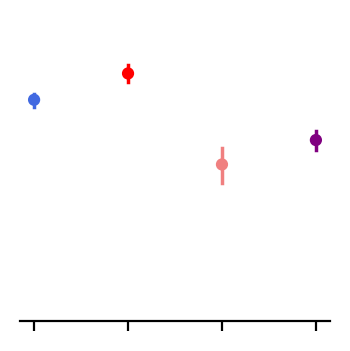

In [12]:
# Create a box plot for the class precision
ylim = [40,105]
xlim = [0,110]
alpha = 0.6
f_size = 8
fig, ax = plt.subplots(1,1,figsize=[2,2], dpi=200)
fig.patch.set_facecolor('white')
color = ['royalblue','red','lightcoral','purple']
sns.pointplot(data=class_recall_df, palette=color,ci=99,errwidth=1.25,scale=0.5)
ax.set_ylim(ylim)
# ax.set_xlim(xlim)
# ax.set_title('Class precision, using ' + str(n_features) + ' features', fontsize=f_size)
# ax.set_ylabel('decimal Correct', fontsize=f_size)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.xaxis.set_ticklabels([])
plt.yticks(fontsize=f_size)
plt.xticks(fontsize=f_size)
# plt.savefig("sg15_box_recall.svg",bbox_inches='tight',dpi=fig.dpi)
plt.plot()